# Completion Rates

In this notebook I track the completion rates of processing each problem in the test and training corpora. Originally when setting no limits on context tokens we were seeing a lot of scoring failing due to the context length being too high for the model, specifically in the ACL corpus. Now we set limits on context lengths of corpora to see if there's any differnce in using the highest limit of 1000 tokens down to 100.

Note the corpus problem counts are in the **utils** script under **_get_corpus_expected_files**.

In [49]:
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from from_root import from_root

sys.path.insert(0, str(from_root("src")))

from utils import list_xlsx_files, _get_corpus_expected_files

In [50]:
models = ["gpt2"]

corpuses = ["Wiki", "Enron", "Perverted Justice", "StackExchange",
            "ACL", "TripAdvisor", "The Apricity", "Koppel's Blogs",
            "The Telegraph", "Reddit"]

data_types = ["training", "test"]

base_loc = "/Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs"

metadata_base_loc = "/Volumes/BCross/datasets/author_verification"

In [51]:
expected_by_corpus_dt = _get_corpus_expected_files()

### Compare Counts

Below is a function which compares the counts of files in each directory to the amount expected

In [52]:
def compare_counts_to_expected_map(
    base_loc,
    data_types,
    corpuses,
    models,
    expected_by_corpus_dt,
    *,
    recursive=False,
    raw_prefix="raw",
):
    """
    Compare actual .xlsx counts on disk vs expected counts (expected varies by (corpus, data_type)).

    Supports:
      {base_loc}/{data_type}/{corpus}/{model}/raw
      {base_loc}/{data_type}/{corpus}/{model}/raw_100
      {base_loc}/{data_type}/{corpus}/{model}/raw_200
      ...

    Adds column:
      - max_context_length: int suffix after f"{raw_prefix}_" or None for f"{raw_prefix}"
    """
    base_loc = Path(base_loc)
    rows = []

    raw_suffix_re = re.compile(rf"^{re.escape(raw_prefix)}_(\d+)$")

    def iter_raw_dirs(model_root: Path):
        """Return list of (data_loc, max_context_length) for raw and raw_### directories."""
        found = []
        if model_root.exists():
            for child in model_root.iterdir():
                if not child.is_dir():
                    continue

                if child.name == raw_prefix:
                    found.append((child, None))
                    continue

                m = raw_suffix_re.match(child.name)
                if m:
                    found.append((child, int(m.group(1))))

        # If nothing exists yet, preserve old behaviour by emitting a single raw row (actual will be 0)
        if not found:
            return [(model_root / raw_prefix, None)]

        # Sort None first, then ascending numeric
        found.sort(key=lambda x: (-1 if x[1] is None else x[1]))
        return found

    for data_type in data_types:
        for corpus in corpuses:
            expected = expected_by_corpus_dt.get((corpus, data_type), None)

            for model in models:
                model_root = base_loc / data_type / corpus / model

                for data_loc, max_context_length in iter_raw_dirs(model_root):
                    if data_loc.exists():
                        actual = len(list_xlsx_files(data_loc, recursive=recursive))
                    else:
                        actual = 0

                    delta = (actual - expected) if expected is not None else None

                    rows.append({
                        "data_type": data_type,
                        "corpus": corpus,
                        "model": model,
                        "max_context_length": max_context_length,
                        "expected_num_files": expected,
                        "actual_num_files": actual,
                        "delta": delta,
                        "missing": (expected - actual) if expected is not None and actual < expected else 0 if expected is not None else None,
                        "extra": (actual - expected) if expected is not None and actual > expected else 0 if expected is not None else None,
                        "complete_pct": (actual / expected) if expected is not None else 0,
                        "missing_pct": 1 - (actual / expected) if expected is not None else 0,
                        "status": (
                            "NOT_STARTED" if expected is not None and actual == 0
                            else "COMPLETED" if expected is not None and actual == expected
                            else "MISSING" if expected is not None and actual < expected
                            else "EXTRA" if expected is not None and actual > expected
                            else "NO_EXPECTATION"
                        ),
                    })

    df = pd.DataFrame(rows)
    if not df.empty:
        df["_mcl_sort"] = df["max_context_length"].fillna(-1).astype(int)
        df = (
            df.sort_values(["data_type", "corpus", "model", "_mcl_sort"])
              .drop(columns=["_mcl_sort"])
              .reset_index(drop=True)
        )

    # Handy lookup now needs max_context_length in the key (otherwise raw/raw_100 collide)
    lookup = {
        (r.data_type, r.corpus, r.model, r.max_context_length): r._asdict()
        for r in df.itertuples(index=False)
    }

    return df, lookup

In [53]:
def filter_corpus_not_started(df):
    """Filter the dataframe for when a corpus has not been started"""
    keys = ["data_type", "corpus", "model"]

    all_not_started = (
        df["status"].eq("NOT_STARTED")
        .groupby([df[k] for k in keys])
        .transform("all")
    )

    df_filtered = df.loc[~all_not_started].copy()
    
    return df_filtered

In [54]:
actual_df, actual_lookup = compare_counts_to_expected_map(base_loc, data_types, corpuses, models, expected_by_corpus_dt)

In [55]:
actual_filtered = filter_corpus_not_started(actual_df)

training = actual_filtered[actual_filtered['data_type'] == 'training'].copy()
test = actual_filtered[actual_filtered['data_type'] == 'test'].copy()

In [56]:
actual_filtered['data_type'].drop_duplicates().tolist()

['test', 'training']

### Overall Completion Rates

In [57]:
def create_stacked_completion_plot(df):
    data_types = df["data_type"].drop_duplicates().tolist()

    if len(data_types) == 1:
        data_type = data_types[0].capitalize()
    else:
        data_type = "Overall"

    # x-axis transform: NaN -> "None"; else int -> str
    df["max_context_cat"] = df["max_context_length"].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # ordered categorical: numeric ascending then "None" last (if present)
    numeric_levels = sorted({int(v) for v in df.loc[df["max_context_cat"] != "None", "max_context_cat"]})
    x_order = [str(v) for v in numeric_levels]
    if (df["max_context_cat"] == "None").any():
        x_order.append("None")

    df["max_context_cat"] = pd.Categorical(df["max_context_cat"], categories=x_order, ordered=True)

    # Aggregate by SUMS, then compute pct = actual / expected (not mean of pcts)
    plot_df = (
        df.groupby("max_context_cat", as_index=False)[["actual_num_files", "expected_num_files"]]
          .sum()
          .sort_values("max_context_cat")
    )

    # complete_pct = actual/expected ; missing_pct = 1 - complete_pct
    expected = plot_df["expected_num_files"].to_numpy()
    actual   = plot_df["actual_num_files"].to_numpy()

    complete = np.divide(actual, expected, out=np.zeros_like(actual, dtype=float), where=expected != 0)
    complete = np.clip(complete, 0, 1)
    missing  = 1 - complete

    x_labels = plot_df["max_context_cat"].astype(str).to_list()
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(x, complete, color="green")
    ax.bar(x, missing, bottom=complete, color="red")

    # label completed % in middle of green segment if > 0
    for i, c in enumerate(complete):
        if c > 0:
            ax.text(
                x[i],
                c / 2,
                f"{round(c * 100, 1)}%",
                ha="center",
                va="center",
                color="white",
                fontsize=9,
                fontweight="bold",
            )

    ax.set_ylim(0, 1)
    ax.set_ylabel("Percent of Files Completed (%)")
    ax.set_xlabel("Max Context Length (Tokens)")
    ax.set_title(f"Percent of Completed vs. Missing Files Processed by Max Context Length - {data_type}", pad=12)

    ticks = np.linspace(0, 1, 6)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{int(t*100)}%" for t in ticks])

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()


<positron-console-cell-58>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


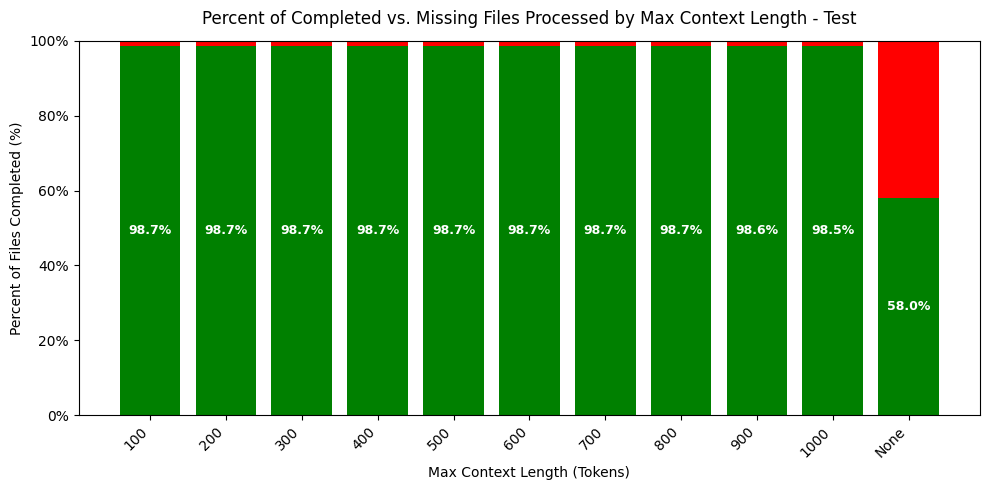

In [58]:
create_stacked_completion_plot(test)

<positron-console-cell-59>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


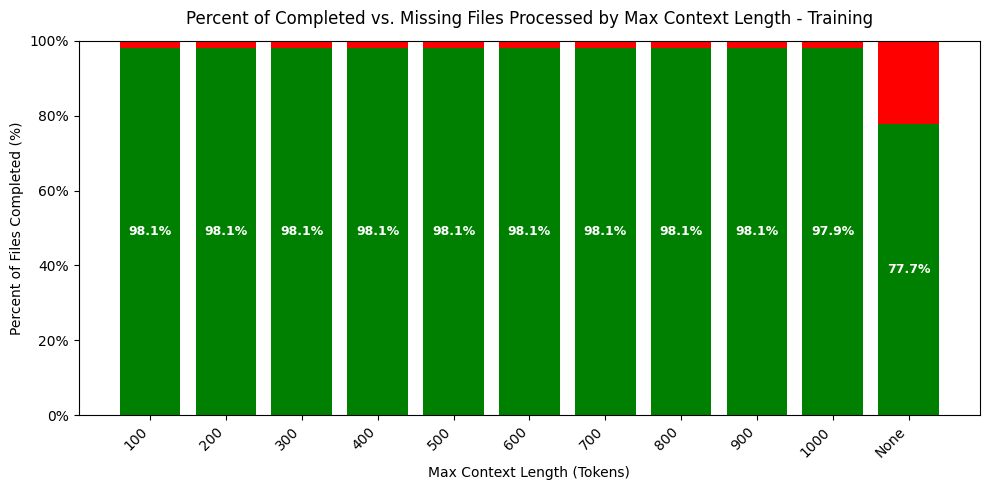

In [59]:
create_stacked_completion_plot(training)

<positron-console-cell-60>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


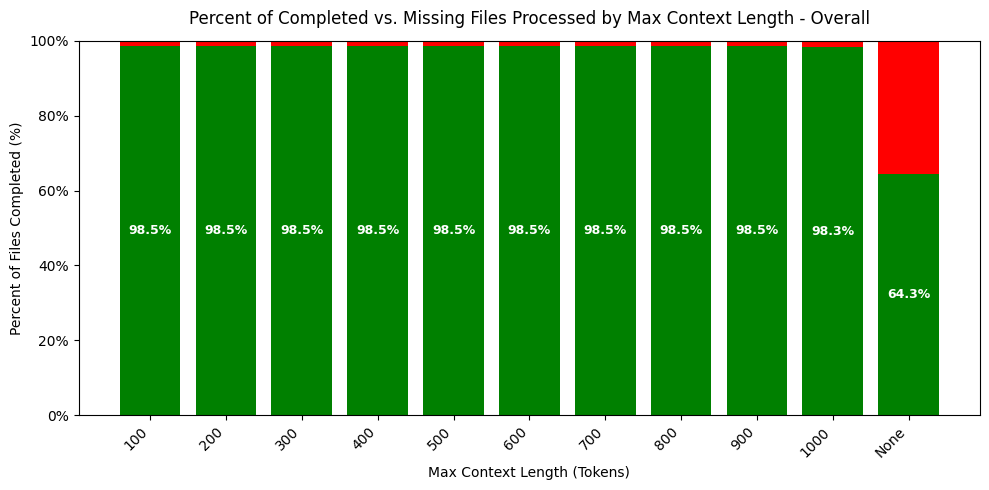

In [60]:
create_stacked_completion_plot(actual_filtered)

### By Corpus Completion Rates

In [61]:
def create_heatmap_completion_plot(df):
    data_types = df["data_type"].drop_duplicates().tolist()

    if len(data_types) == 1:
        data_type = data_types[0].capitalize()
    else:
        data_type = "Overall"

    # x-axis transform: NaN -> "None"; else int -> str
    df["max_context_cat"] = df["max_context_length"].map(
        lambda v: "None" if pd.isna(v) else str(int(v))
    )

    # ordered categorical: numeric ascending then "None" last (if present)
    numeric_levels = sorted({int(v) for v in df.loc[df["max_context_cat"] != "None", "max_context_cat"]})
    col_order = [str(v) for v in numeric_levels]
    if (df["max_context_cat"] == "None").any():
        col_order.append("None")

    df["max_context_cat"] = pd.Categorical(df["max_context_cat"], categories=col_order, ordered=True)

    # Pivot using SUMS of actual/expected, then compute pct = actual/expected
    sums = (
        df.pivot_table(
            index="corpus",
            columns="max_context_cat",
            values=["actual_num_files", "expected_num_files"],
            aggfunc="sum"
        )
        .sort_index()
    )

    # Ensure full column order exists (for both top-level columns)
    for top in ["actual_num_files", "expected_num_files"]:
        if top in sums.columns.get_level_values(0):
            sums[top] = sums[top].reindex(columns=col_order)

    actual = sums["actual_num_files"]
    expected = sums["expected_num_files"]

    heat = actual.divide(expected).clip(lower=0, upper=1)  # complete_pct 0–1
    heat = heat.reindex(columns=col_order)

    data = heat.to_numpy()
    masked = np.ma.masked_invalid(data)

    # light green -> dark green colormap
    greens = LinearSegmentedColormap.from_list(
        "light_to_dark_green",
        ["#e8f5e9", "#1b5e20"]
    ).copy()
    greens.set_bad(color="lightgrey")

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(masked, aspect="auto", vmin=0, vmax=1, cmap=greens)

    ax.set_xlabel("Max Context Length (Tokens)")
    ax.set_ylabel("Corpus")
    ax.set_title(f"{data_type} - Completion % Heatmap (0–1)")

    ax.set_xticks(np.arange(heat.shape[1]))
    ax.set_xticklabels([str(c) for c in heat.columns], rotation=45, ha="right")

    ax.set_yticks(np.arange(heat.shape[0]))
    ax.set_yticklabels(heat.index)

    # Cell labels: percent, 1dp (skip NaNs)
    for i in range(heat.shape[0]):
        for j in range(heat.shape[1]):
            v = data[i, j]
            if np.isfinite(v):
                ax.text(
                    j, i,
                    f"{v*100:.1f}%",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="black" if v < 0.55 else "white"
                )

    # Faint grey gridlines between cells
    ax.set_xticks(np.arange(-0.5, heat.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, heat.shape[0], 1), minor=True)
    ax.grid(which="minor", color="grey", linestyle="-", linewidth=0.5, alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    cbar = fig.colorbar(im, ax=ax)

    # show 0–100% instead of 0–1
    ticks = np.linspace(0, 1, 6)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t*100:.0f}%" for t in ticks])
    cbar.set_label("Complete (%)")

    plt.tight_layout()
    plt.show()


<positron-console-cell-62>:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


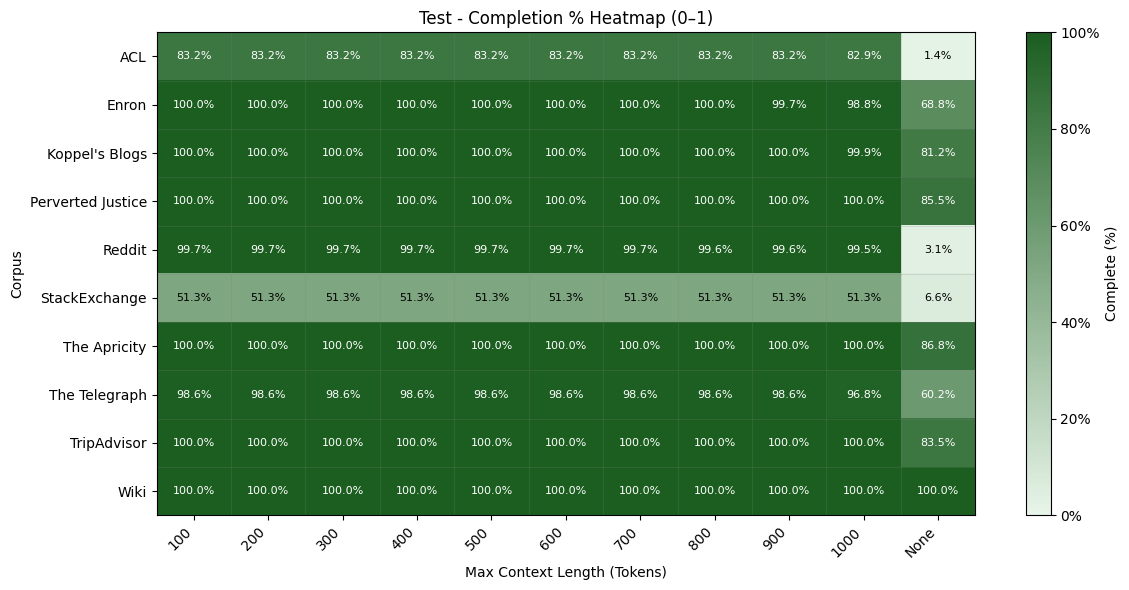

In [62]:
create_heatmap_completion_plot(test)

<positron-console-cell-63>:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


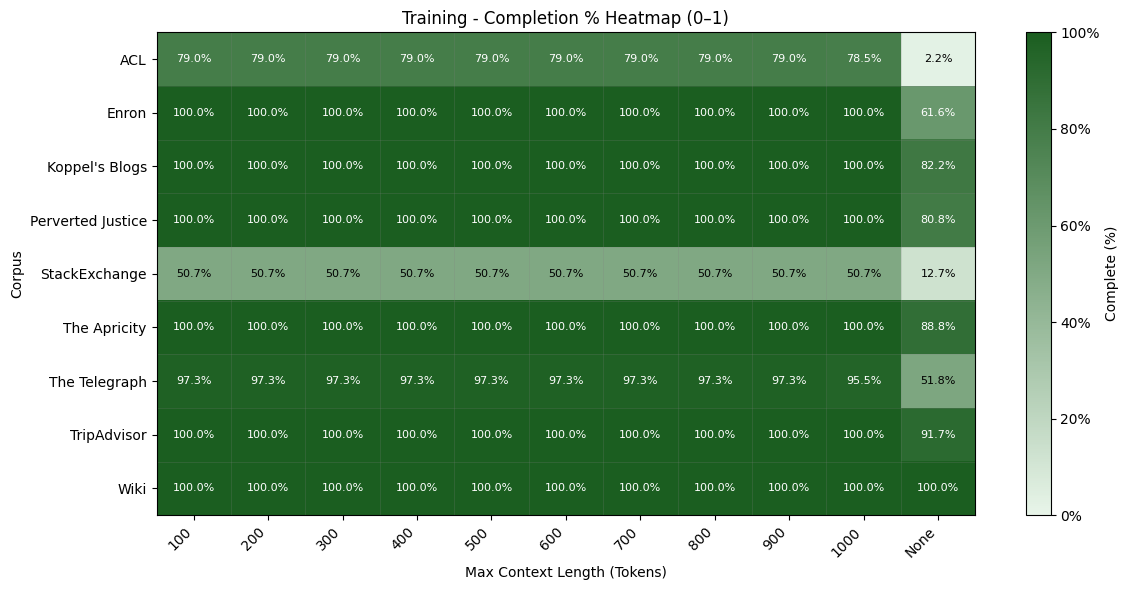

In [63]:
create_heatmap_completion_plot(training)

<positron-console-cell-64>:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


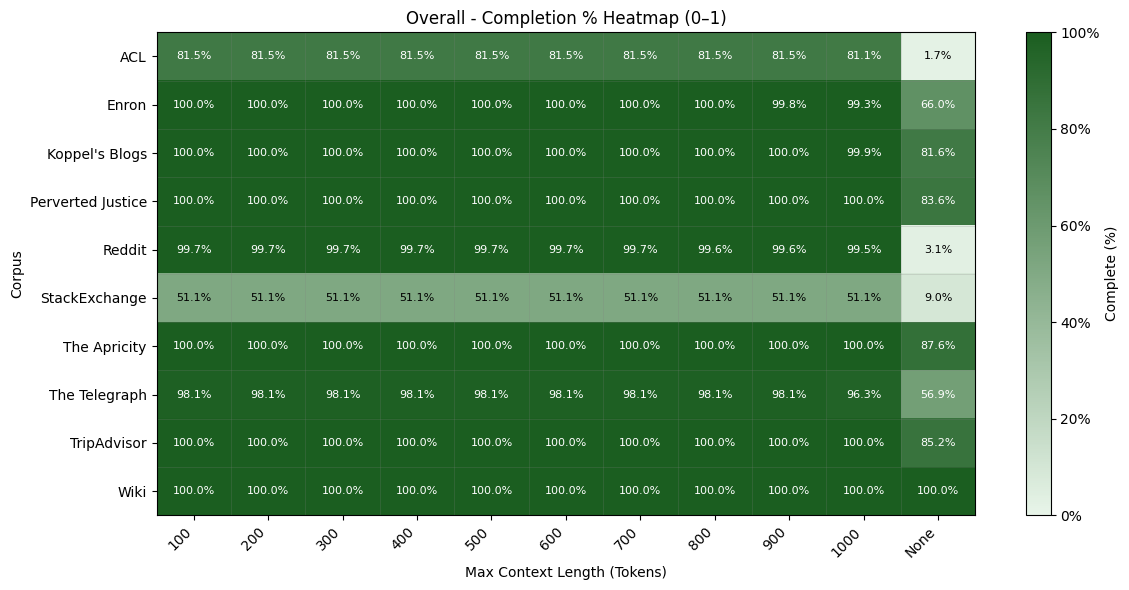

In [64]:
create_heatmap_completion_plot(actual_filtered)